# Beispiel 3.5

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import pandas as pd

werbung = pd.read_csv("./Daten/Werbung.csv").drop(["Unnamed: 0"], axis=1)

werbung.head()
print(werbung.head())

      TV  Radio  Zeitung  Verkauf
0  230.1   37.8     69.2     22.1
1   44.5   39.3     45.1     10.4
2   17.2   45.9     69.3      9.3
3  151.5   41.3     58.5     18.5
4  180.8   10.8     58.4     12.9


In [4]:
with pm.Model() as model_lb:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=100)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", 10)
    mu = pm.Deterministic("mu", beta_0 + beta_1 * werbung.TV)
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=werbung.Verkauf)
    idata_lb = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


/opt/conda/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [5]:
posterior = az.extract(idata_lb, num_samples=50)
x_plot = xr.DataArray(
    np.linspace(werbung.TV.min(), werbung.TV.max(), 50), dims="plot_id"
)
mean_line = posterior["beta_0"].mean() + posterior["beta_1"].mean() * x_plot
lines = posterior["beta_0"] + posterior["beta_1"] * x_plot

- Die Funktion `az.extract` fügt die Dimensionen von `chain` und `draw` in einer `sample` Dimension zusammen. Falls wir zum Beispiel `chains=4` und `draws=1000` haben, ergibt dies 4000 samples. Dies wird für die weitere Bearbeitung von Bedeutung sein.

- Wir benützen das `num_samples` Argument, um eine Teilstichprobe von der Posterior-Verteilung zu entnehmen. `az.extract` operiert auf der Posterior-Gruppe. Falls Informationen von einer anderen Gruppe benötigt werden, kann dies mit Hilfe des `group` Arguments spezifiziert werden.

- Wir definieren ein `DataArray` mit dem Namen `x_plot`, welches gleich grosse Intervalle zwischen dem Minimum und Maximum von `TV` macht. Hier sind es 50 Intervalle.

- Mit `mean_line` berechnen wir explizit den Erwartungswert der Posterior-Verteilung von $\mu$ für jeden Wert in `x_plot`, und zwar mit den Mittelwerten von `posterior["beta_0"]` und `posterior["beta_1"]`.

- Mit `lines` berechnen wir 50 Regressionsgerade aus der Teilstichprobe bestehend aus 50 Werten von `posterior["beta_0"]` und `posterior["beta_1"]`, wobei `posterior["beta_0"].size}=50`.

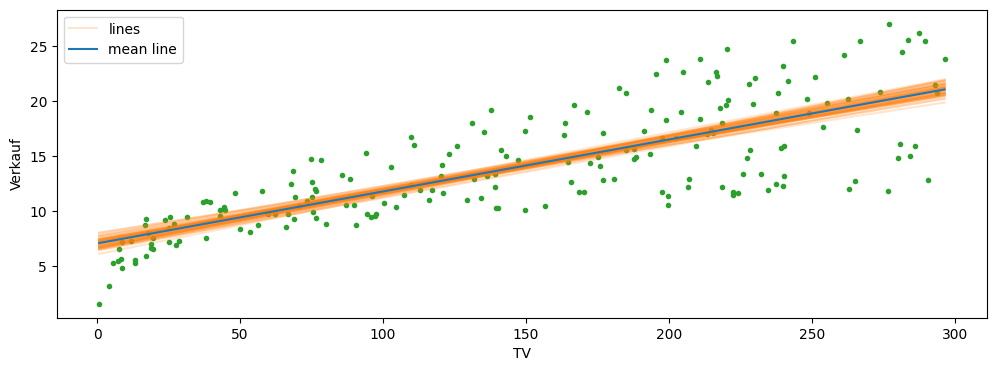

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4), sharey=True)
axes.plot(werbung.TV, werbung.Verkauf, "C2.", zorder=-3)
lines_ = axes.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
axes.plot(x_plot, mean_line, c="C0", label="mean line")
axes.set_xlabel("TV")
axes.set_ylabel("Verkauf")
axes.legend()

Anstelle einer Teilmenge bestehend aus 50 Stichproben aus der Posterior-Verteilung, könnten 
wir auch alle verfügbaren Posterior Stichproben von $\mu$ benützen, um das 94\% HDI zu berechnen. Dies erfolgt mit Hilfe des folgenden Codes:

In [7]:
hdi_lines = az.hdi(idata_lb.posterior["mu"])

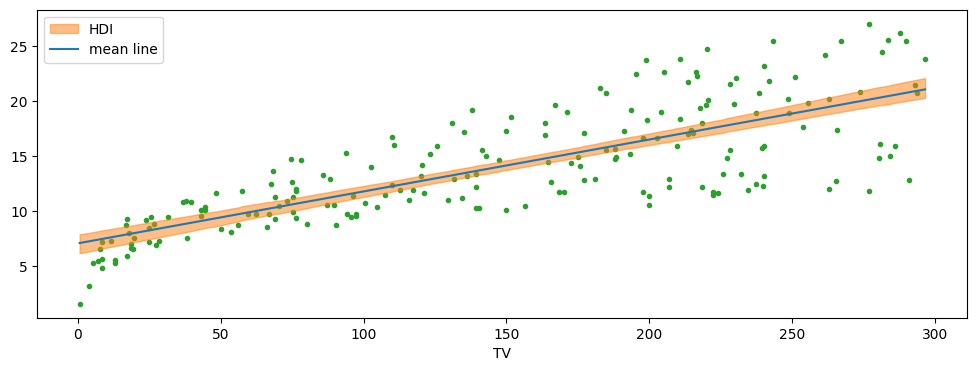

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4), sharey=True)
axes.plot(werbung.TV, werbung.Verkauf, "C2.", zorder=-3)
idx = np.argsort(werbung.TV.values)
axes.fill_between(
    werbung.TV[idx],
    hdi_lines["mu"][:, 0][idx],
    hdi_lines["mu"][:, 1][idx],
    color="C1",
    label="HDI",
    alpha=0.5,
)
axes.plot(x_plot, mean_line, c="C0", label="mean line")
axes.set_xlabel("TV")
axes.legend()